In [1]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer

import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

np.random.seed(0)
torch.manual_seed(0)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
sns.set(style = 'white', font_scale = 2)

In [5]:
with open("de_to_en.txt", "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

text_pairs = []
for l in lines:
    appendage = l.split("\t")
    text_pairs.append(appendage)

In [6]:
# Print the first ten translated lines
for i in range(10): 
    print(text_pairs[i][0], text_pairs[i][1])

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche. Two young, White males are outside near many bushes.
Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem. Several men in hard hats are operating a giant pulley system.
Ein kleines Mädchen klettert in ein Spielhaus aus Holz. A little girl climbing into a wooden playhouse.
Ein Mann in einem blauen Hemd steht auf einer Leiter und putzt ein Fenster. A man in a blue shirt is standing on a ladder cleaning a window.
Zwei Männer stehen am Herd und bereiten Essen zu. Two men are at the stove preparing food.
Ein Mann in grün hält eine Gitarre, während der andere Mann sein Hemd ansieht. A man in green holds a guitar while the other man observes his shirt.
Ein Mann lächelt einen ausgestopften Löwen an. A man is smiling at a stuffed lion
Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt. A trendy girl talking on her cellphone while gliding slowly down the street.
Eine Frau mit einer g

In [7]:
import locale
def getpreferredencoding(do_setlocale=True):
  return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [8]:
!python -m spacy download en_core_web_sm

!python -m spacy download de_core_news_sm

2023-05-09 23:30:05.722717: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-09 23:30:06.738831: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-09 23:30:08.066147: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-09 23:30:08.066591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

In [9]:
de_token_transform = get_tokenizer('spacy', language='de_core_news_sm')
en_token_transform = get_tokenizer('spacy', language='en_core_web_sm')

In [10]:
#SOURCE='de'
#TARGET='en'
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# assign tokenizers to appropriate keys in your token_transform dictionary

token_transform = {}
token_transform[SRC_LANGUAGE] = de_token_transform
token_transform[TGT_LANGUAGE] = en_token_transform



In [11]:
# Tokenize the first line of each dataset, and print the tokenized version of it
de_0_tokenized = token_transform[SRC_LANGUAGE](text_pairs[0][1])
en_0_tokenized = token_transform[TGT_LANGUAGE](text_pairs[0][0])

print(en_0_tokenized)
print(de_0_tokenized)

['Zwei', 'junge', 'weiße', 'Männer', 'sind', 'i', 'm', 'Freien', 'in', 'der', 'Nähe', 'vieler', 'Büsche', '.']
['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [12]:
# Special tokens: a "unique" filler-token to use when we can't tokenize a particular word, a "padding" token, a "beginning-of-sentence" token and an "end-of-sentence" token. 
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>']

# And their special indeces in our vocabulary
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# A helper function that converts a list of strings into a list of lists-of-tokens
def yield_tokens(data_iter, language):
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        try:
          yield token_transform[language](data_sample[language_index[language]])
        except IndexError:
          print(f"token_transform.keys(): {token_transform.keys()}")
          print(f"language: {language}")
          print(f"data_sample: {data_sample}")
          print(f"language_index: {language_index}")
          raise IndexError

# Create a vocabulary object for each language using the build_vocab_from_iterator function
vocab_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Invoke torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(text_pairs, ln),
                                                    min_freq=1,
                                                    specials=special_tokens,
                                                    special_first=True)


for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

# Let's see the first 20 words in each vocabulary
print(vocab_transform[SRC_LANGUAGE].get_itos()[:20])
print(vocab_transform[TGT_LANGUAGE].get_itos()[:20]) 

['<unk>', '<pad>', '<bos>', '<eos>', '.', 'Ein', 'einem', 'in', 'und', ',', 'mit', 'auf', 'Mann', 'einer', 'Eine', 'ein', 'der', 'Frau', 'eine', 'die']
['<unk>', '<pad>', '<bos>', '<eos>', 'a', '.', 'A', 'in', 'the', 'on', 'is', 'and', 'man', 'of', 'with', ',', 'woman', 'are', 'to', 'Two']


In [13]:
# Shuffle the text pairs
shuffler = np.random.permutation(len(text_pairs))
text_pairs = [text_pairs[i] for i in shuffler] 

# Train-validate-test split: 80-10-10
n_train = int(0.8*len(text_pairs))
train_pairs = text_pairs[:n_train] 

n_val = int(0.1*len(text_pairs))
val_pairs = text_pairs[n_train:n_train+n_val]

n_test = int(0.1*len(text_pairs))
test_pairs = text_pairs[n_train+n_val:]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

31019 total pairs
24815 training pairs
3101 validation pairs
3103 test pairs


In [14]:
# Helper
def generate_square_subsequent_mask(sz): 
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Mask function
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [15]:
# A helper function to club together sequential operations
def sequential_transforms(*transforms): 
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# Adds BOS/EOS and creates a tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# ``src`` and ``tgt`` language text transforms convert the raw strings into tensors indices
text_transform = {} 
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# The "collation" function collates data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [16]:
# This function trains the model for a single epoch
def train_epoch(model, optimizer):
    model.train()
    loss_list = []
    train_iter = train_pairs
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        loss_list.append(loss.item())

    return loss_list

# Evaluates the model
def evaluate(model):
    model.eval()
    loss_list = []

    val_iter = val_pairs
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss_list.append(loss.item())

    return loss_list

In [17]:

class PositionalEncoding(nn.Module): # <-- "Embedding"
    def __init__(self, emb_size, dropout, maxlen = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])


class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Sequence-to-sequence transformer 
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers,
                 num_decoder_layers,
                 embedding_size,
                 num_heads,
                 src_vocab_size,
                 tgt_vocab_size,
                 dim_feedforward = 512,
                 dropout = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=embedding_size,
                                       nhead=num_heads,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(embedding_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, embedding_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(
            embedding_size, dropout=dropout)

    def forward(self,
                src,
                trg,
                src_mask,
                tgt_mask,
                src_padding_mask,
                tgt_padding_mask,
                memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src)) # source sequence --> token embedding --> positional encoding
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg)) # target sequence --> token embedding --> positional encoding
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None, 
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [18]:

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE]) 
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NUM_HEADS = 8 
FFN_HID_DIM = 512 
BATCH_SIZE = 32
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
NUM_EPOCHS = 6

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NUM_HEADS, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

In [19]:
train_loss_list=[]
validation_loss_list=[]

In [20]:
#transformer=transformer.cuda()


In [21]:

train_loss_list = []
val_loss_list = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    train_loss_list.extend(train_loss)
    end_time = timer()
    val_loss = evaluate(transformer)
    val_loss_list.extend(val_loss)
    print((f"Epoch: {epoch}, Epoch time = {(end_time - start_time):.3f}s"))


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 1, Epoch time = 46.170s
Epoch: 2, Epoch time = 43.238s
Epoch: 3, Epoch time = 39.422s
Epoch: 4, Epoch time = 39.751s
Epoch: 5, Epoch time = 39.334s
Epoch: 6, Epoch time = 39.482s


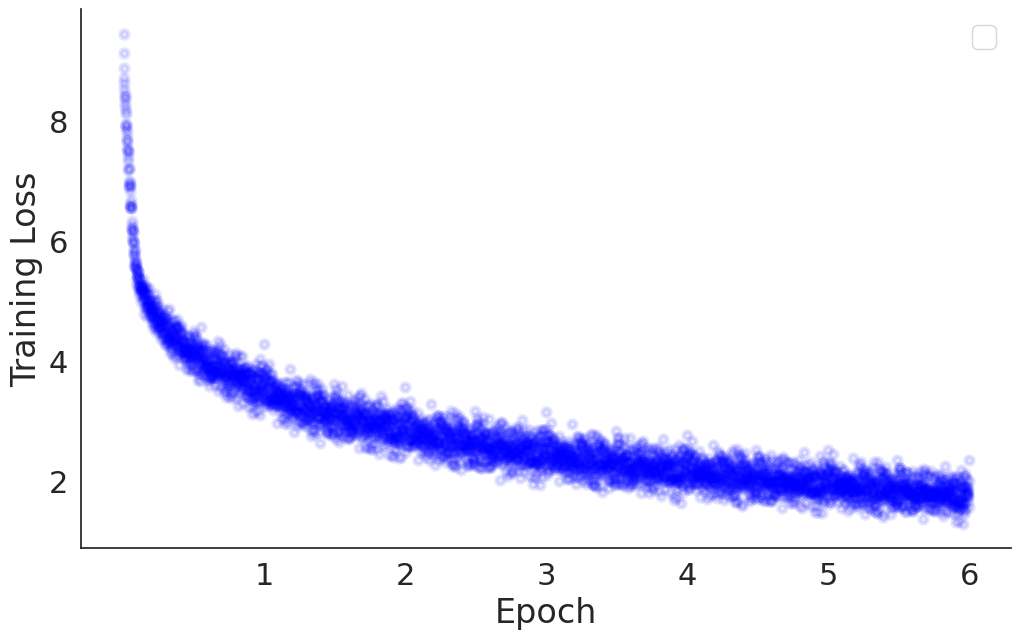

In [22]:
# Plot the loss
plt.figure(figsize = (12, 7))

plt.scatter(range(len(train_loss_list)), train_loss_list, color = 'blue', linewidth = 3, alpha=0.1)
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.xticks(ticks = [(i+1)*len(train_loss_list)//NUM_EPOCHS for i in range(NUM_EPOCHS)], labels=[f"{i+1}" for i in range(NUM_EPOCHS)])
plt.legend()
sns.despine()

In [25]:

def decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys

def translate(model, src_sentence):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")


In [26]:
for i in range(10):
    test_pair = test_pairs[-i]
    test_str_de = test_pair[0]
    test_str_en = test_pair[1]
    print(f"Target: {test_str_en}")
    print("Model output:", translate(transformer, test_str_de))
    print("")

Target: A group of faithful shoppers bear the cold while one points to his favorite store.
Model output:  A group of students are gathered around the front of a wooden truck while one shows . 

Target: I think the construction work is going on here.
Model output:  She is about to get off of construction workers . 

Target: A motorcyclist speeding along a road on a green Kawasaki sport motorcycle.
Model output:  A motorcycle rider is riding a green wooden road with green green plastic balloon . 

Target: Skater boy does a trick and gets his photo taken in midair.
Model output:  A skier is doing a trick while being pulled up in the air . 

Target: People rock climbing and hiking near a lake.
Model output:  A climber and hiker are near a lake . 

Target: A man and woman are in the kitchen and a package of Challenge butter is in the foreground.
Model output:  A man and woman in the kitchen and a gold - sleeved shirt stands in the foreground . 

Target: A white man is seen in a swimming poo